In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Value:
    def __init__(
        self, data: float, _children: tuple = (), _op: str = "", label: str = ""
    ):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self.label = label
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), _op="+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), _op="*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __truediv__(self, other):  # self / other
        out = self * other**-1
        return out

    def __pow__(self, other):
        if not isinstance(other, (int, float)):
            raise ValueError("Only supporting int/float for now")
        out = Value(self.data**other, (self,), _op=f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(np.exp(x), (self,), _op="exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        out = Value((np.exp(2 * x) - 1) / (np.exp(2 * x) + 1), (self,), _op="tanh")

        def _backward():
            self.grad += (1 - out.data**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topological_sort(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological_sort(child)
                topo.append(v)

        build_topological_sort(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value(data={self.data})"

In [3]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [4]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"
o.backward()

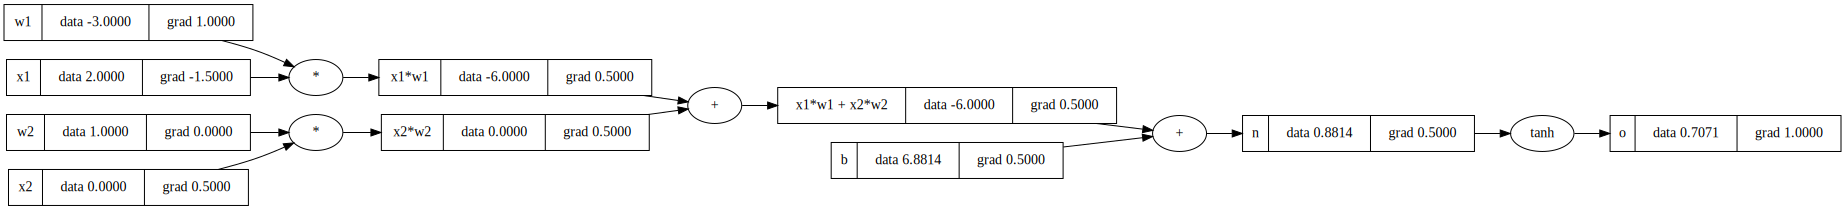

In [5]:
draw_dot(o)

In [6]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
# ============
e = (2 * n).exp()
o = (e - 1) / (e + 1)
o.label = "o"
# ============
o.backward()

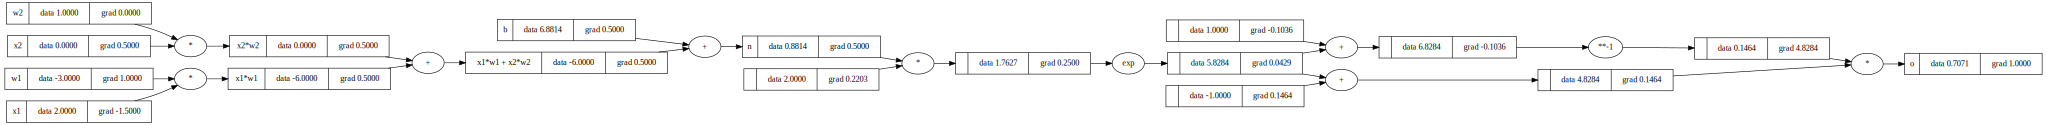

In [7]:
draw_dot(o)

### Let's switch to PyTorch

In [8]:
import torch

x1 = torch.Tensor([2.0]).requires_grad_()
x2 = torch.Tensor([0.0]).requires_grad_()
w1 = torch.Tensor([-3.0]).requires_grad_()
w2 = torch.Tensor([1.0]).requires_grad_()
b = torch.Tensor([6.8813735870195432]).requires_grad_()

n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(f"o: {o.data}")

o.backward()

print(f"x1: {x1.grad}")
print(f"w1: {w1.grad}")
print(f"x2: {x2.grad}")
print(f"w2: {w2.grad}")

o: tensor([0.7071])
x1: tensor([-1.5000])
w1: tensor([1.0000])
x2: tensor([0.5000])
w2: tensor([0.])


### Let's create a simple Neural Network using our Value object

In [9]:
import random


class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [10]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.43931053284565)

In [11]:
# draw_dot(n(x))

In [12]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [13]:
y_preds = [n(x) for x in xs]
y_preds

[Value(data=-0.43931053284565),
 Value(data=-0.4971061377067275),
 Value(data=0.3083594433296202),
 Value(data=-0.3945220088632846)]

In [14]:
loss = sum((ypred - ytrue) ** 2 for ypred, ytrue in zip(y_preds, ys))
loss

Value(data=5.981013112846559)

In [15]:
loss.backward()

In [16]:
# draw_dot(loss)

In [17]:
n.parameters()

[Value(data=0.10176250160377664),
 Value(data=0.3390091727600617),
 Value(data=0.3078476894076789),
 Value(data=0.14320643903815045),
 Value(data=-0.6639206482633278),
 Value(data=0.26624281727835863),
 Value(data=0.6553987462820801),
 Value(data=0.4994311025166924),
 Value(data=0.4801281703591467),
 Value(data=0.5620036803641402),
 Value(data=-0.4708203807879974),
 Value(data=0.42695535798788),
 Value(data=-0.679082646713268),
 Value(data=-0.08636782564261947),
 Value(data=0.44785572100100546),
 Value(data=-0.01618951207971353),
 Value(data=-0.0820271204571823),
 Value(data=-0.6931350272490253),
 Value(data=0.19308675138425135),
 Value(data=0.06110814668562137),
 Value(data=0.8763115502964758),
 Value(data=-0.8163009283133655),
 Value(data=-0.7258928445761188),
 Value(data=0.6496591066538768),
 Value(data=-0.8908772994667475),
 Value(data=0.8716033610695879),
 Value(data=-0.2547969011967717),
 Value(data=0.5093806081663945),
 Value(data=-0.2075720076684089),
 Value(data=-0.35582126155

In [18]:
len(n.parameters())

41

In [19]:
n.layers[0].neurons[0].w[0].data

0.10176250160377664

In [20]:
n.layers[0].neurons[0].w[0].grad

0.2870106838530112

The gradient tells us how much the loss function would change if were to slightly increase the value of this parameter.

Since the gradient is ($-1.655997$), although this might change the next time we re-run the notebook, we want to increase the weight to decrease the loss even further.

In [21]:
loss

Value(data=5.981013112846559)

In [22]:
for p in n.parameters():
    p.data -= 0.01 * p.grad

In [23]:
n.layers[0].neurons[0].w[0].data

0.09889239476524653

In [24]:
y_preds = [n(x) for x in xs]
loss = sum((ypred - ytrue) ** 2 for ypred, ytrue in zip(y_preds, ys))
loss

Value(data=5.497637729597988)

As expected, the loss decreased.

In [25]:
for epoch in range(20):
    # forward pass
    y_preds = [n(x) for x in xs]
    loss = sum((ypred - ytrue) ** 2 for ypred, ytrue in zip(y_preds, ys))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data -= 0.1 * p.grad

    print(f"epoch {epoch}: {loss.data:.6f}")

epoch 0: 5.497638
epoch 1: 4.607919
epoch 2: 4.073022
epoch 3: 3.888311
epoch 4: 3.683598
epoch 5: 3.494047
epoch 6: 3.076752
epoch 7: 2.804637
epoch 8: 1.819010
epoch 9: 1.448448
epoch 10: 0.409605
epoch 11: 0.139379
epoch 12: 0.084965
epoch 13: 0.062169
epoch 14: 0.049085
epoch 15: 0.040576
epoch 16: 0.034586
epoch 17: 0.030136
epoch 18: 0.026696
epoch 19: 0.023957


In [26]:
y_preds

[Value(data=0.9194541645746355),
 Value(data=-0.9398622377236191),
 Value(data=-0.9327576479651543),
 Value(data=0.9034025256481927)]

In [27]:
ys

[1.0, -1.0, -1.0, 1.0]